In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(2,110))
vvel_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [3]:
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)


def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a*3)

window_width=51
weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=uvel_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [4]:
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

uvel_unf_mr = uvel_unfiltered-uvel_unfiltered.mean('time')
vvel_unf_mr = vvel_unfiltered-vvel_unfiltered.mean('time')
uvel_f_mr = uvel_filtered-uvel_unfiltered.mean('time')
vvel_f_mr = vvel_filtered-vvel_unfiltered.mean('time')
uvel_ef_mr = u_eul_filtered-uvel_unfiltered.mean('time')
vvel_ef_mr = v_eul_filtered-vvel_unfiltered.mean('time')
eta_ef_mr = eta_eul_filtered-eta_mean.Eta

In [5]:
z_un=uvel_unf_mr.drop('niter')+1j*vvel_unf_mr.drop('niter')
with ProgressBar():
    z2_un = xrft.power_spectrum(z_un.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[#                                       ] | 3% Completed |  7.6s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 46.1s


In [6]:
z_f=uvel_f_mr.drop('niter')+1j*vvel_f_mr.drop('niter')
with ProgressBar():
    z2_f = xrft.power_spectrum(z_f.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[                                        ] | 0% Completed |  5.7s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 35.0s


In [7]:
z_ef=uvel_ef_mr+1j*vvel_ef_mr
with ProgressBar():
    z2_ef = xrft.power_spectrum(z_ef.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[                                        ] | 1% Completed |  4.8s

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 57.1s


In [8]:
spec0 = int((z2_ef['freq_time'].size-1)/2)
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)
fs = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
fn = 2*2*np.pi/24/3600*np.sin(-26.7*np.pi/180)

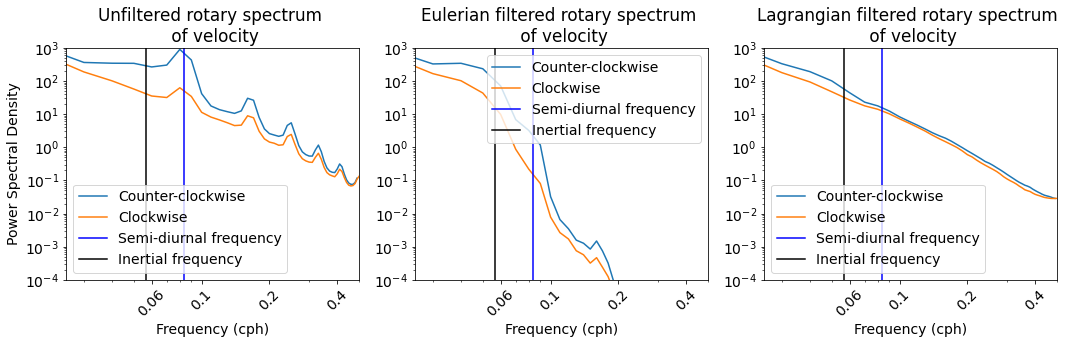

In [9]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(z2_un.freq_time[spec0:]*3600,z2_un.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_un.freq_time[spec0::-1]*3600,z2_un.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(z2_ef.freq_time[spec0:]*3600,z2_ef.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_ef.freq_time[spec0::-1]*3600,z2_ef.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(133)
plt.plot(z2_f.freq_time[spec0:]*3600,z2_f.mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_f.freq_time[spec0::-1]*3600,z2_f.mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('Rotary_filt_unfilt.png')

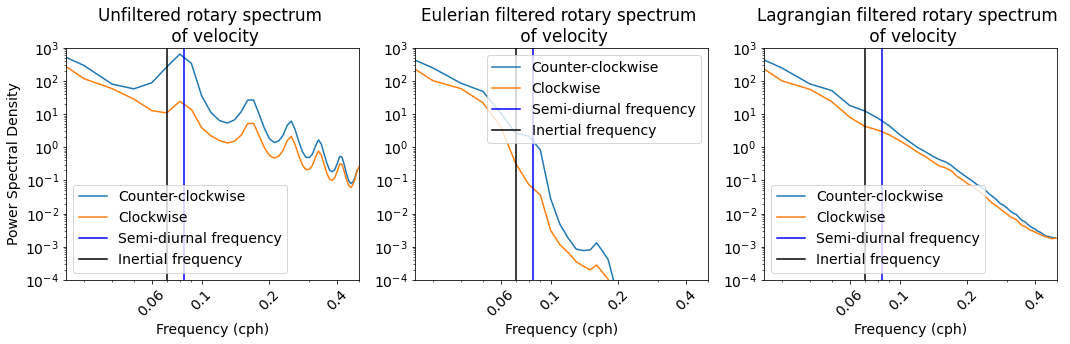

In [10]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(z2_un.freq_time[spec0:]*3600,z2_un.isel(j=slice(0,440)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_un.freq_time[spec0::-1]*3600,z2_un.isel(j=slice(0,440)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(z2_ef.freq_time[spec0:]*3600,z2_ef.isel(j=slice(0,440)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_ef.freq_time[spec0::-1]*3600,z2_ef.isel(j=slice(0,440)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(133)
plt.plot(z2_f.freq_time[spec0:]*3600,z2_f.isel(j=slice(0,440)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_f.freq_time[spec0::-1]*3600,z2_f.isel(j=slice(0,440)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('Rotary_filt_unfilt.png')

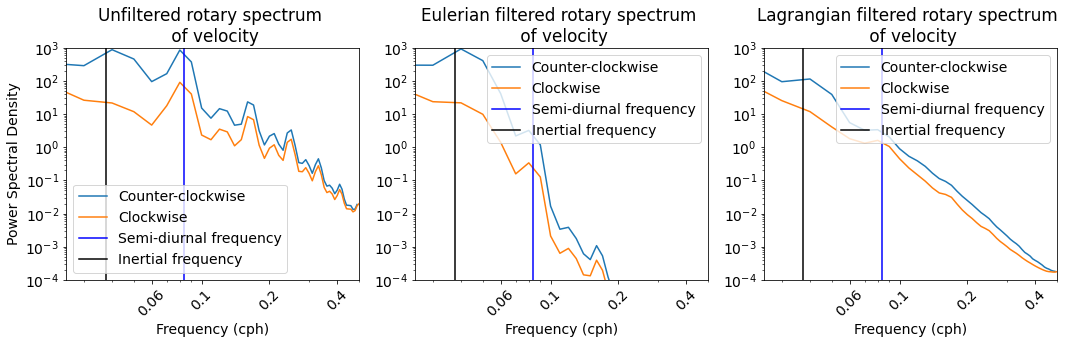

In [11]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(z2_un.freq_time[spec0:]*3600,z2_un.isel(j=slice(1860,2200)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_un.freq_time[spec0::-1]*3600,z2_un.isel(j=slice(1860,2200)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)
plt.ylabel('Power Spectral Density')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(z2_ef.freq_time[spec0:]*3600,z2_ef.isel(j=slice(1860,2200)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_ef.freq_time[spec0::-1]*3600,z2_ef.isel(j=slice(1860,2200)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(133)
plt.plot(z2_f.freq_time[spec0:]*3600,z2_f.isel(j=slice(1860,2200)).mean(['i','j'])[spec0:],label='Counter-clockwise')
plt.plot(-z2_f.freq_time[spec0::-1]*3600,z2_f.isel(j=slice(1860,2200)).mean(['i','j'])[spec0::-1],label='Clockwise')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered rotary spectrum \n of velocity')
plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('Rotary_filt_unfilt.png')

In [23]:
1/0.9

1.1111111111111112